# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html
- Conceptual: https://medium.com/@hirotoschwert/digging-into-detectron-2-part-5-6e220d762f9
- Conceptual: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 11.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=c9bb7323514354fd7011e242e649655fc77153f0b44148e6d5e2e7d9b35e0ec6
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 871kB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210204-cp36-none-any.whl size=44945 sha256=b5139078b6e1379edbde5a28dd1054ba5673a8338eea96067a7a64f1d46080bd
  Stored in directory: /root/.cache/pip/wheels/7a/d5/3d/1393f94e0a0c6345f674387da5bd382c9aba98a23371a3804e
  Created wheel for iopath: filename=iopath-0.1.3-cp36-none-any.whl size=11169 sha256=cf8b1646fa0e52e80203c4a0bb9ec6d51904faa98f9b5b07b2b782e322659e0a
  Stored in directory: /root/.cache/pip/wheels/a9/1d/55/94a55e032409ac7617f9cbb88a0fa2cf4e7208806c29730804
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0

In [ ]:
!nvidia-smi

Wed Feb 10 07:56:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Registration of the custom dataset to detectron2

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')

# Model Loading

In [ ]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/retinanet_R_101_FPN_3x_2"  # Replace w/ folder

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [ ]:
from detectron2.engine import DefaultTrainer
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))  # Replace w/ config
cfg.DATASETS.TRAIN = (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ship)
cfg.OUTPUT_DIR = model_name

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # (default: 0.05)
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5  # (default: 0.5)

#cfg.MODEL.DEVICE = 'cpu'

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[02/10 07:57:55 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # (default: 0.05)
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5  # (default: 0.5)

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [ ]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [ ]:
os.makedirs(model_name + "/predImages_eval", exist_ok=True)  # Make a directory for output images

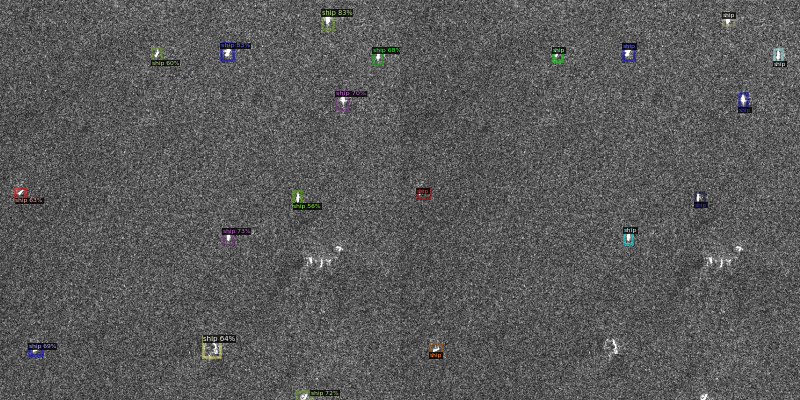

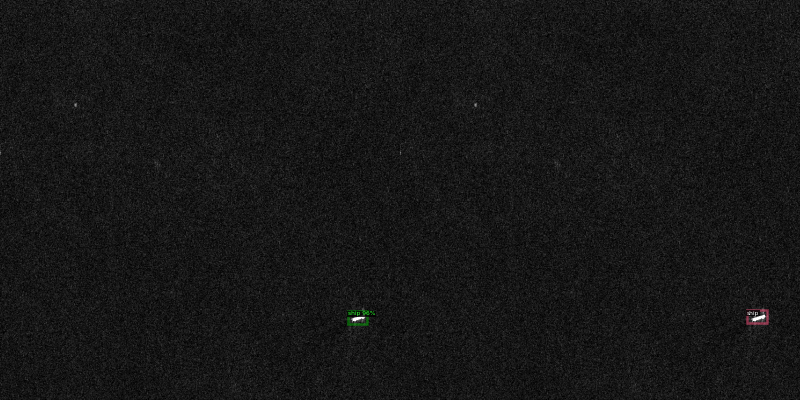

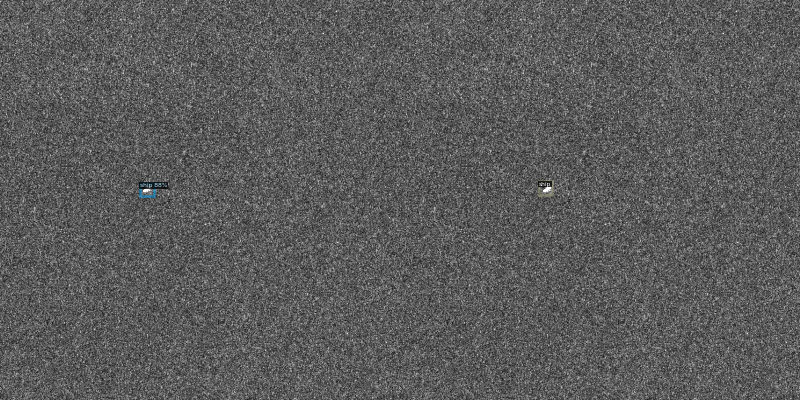

In [ ]:
from cv2 import hconcat
random.seed(1)
#set.seed(1)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3) # display an image
  cv2.imwrite(model_name + '/predImages_eval/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Evaluation using the COCO Evaluator

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/10 08:02:08 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [02/10 08:02:08 d2.data.datasets.coco]: Using previously cached COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_2/ssdd_test_offshore_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[02/10 08:02:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[02/10 08:02:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 08:02:09 d2.data.common]: Serializing 2234 elements to byte tensors and concatenating them all ...
[02/10 08:02:09 d2.data.common]: Serialized dataset takes 0.41 MiB
[02/10 08:02:09 d2.evaluation.eval

In [ ]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/10 08:16:42 d2.evaluation.coco_evaluation]: 'ssdd_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [02/10 08:16:42 d2.data.datasets.coco]: Using previously cached COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_2/ssdd_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[02/10 08:16:42 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[02/10 08:16:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 08:16:42 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[02/10 08:16:42 d2.data.common]: Serialized dataset takes 0.53 MiB
[02/10 08:16:42 d2.evaluation.evaluator]: Start infe

In [ ]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[02/10 08:34:55 d2.evaluation.coco_evaluation]: 'ssdd_test_inshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [02/10 08:34:55 d2.data.datasets.coco]: Using previously cached COCO format annotations at './ModelOutput/retinanet_R_101_FPN_3x_2/ssdd_test_inshore_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[02/10 08:34:56 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[02/10 08:34:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 08:34:56 d2.data.common]: Serializing 766 elements to byte tensors and concatenating them all ...
[02/10 08:34:56 d2.data.common]: Serialized dataset takes 0.14 MiB
[02/10 08:34:56 d2.evaluation.evaluat

In [ ]:
%ls ./ModelOutput/retinanet_R_101_FPN_3x_2

coco_instances_results.json
events.out.tfevents.1612300412.44018e83b0db.146.0
events.out.tfevents.1612303697.990e85fdca37.144.0
events.out.tfevents.1612550323.0045d9a32da7.147.0
events.out.tfevents.1612943917.1a9c30fd8ab1.148.0
instances_predictions.pth
last_checkpoint
metrics.json
model_0004999.pth
model_0009999.pth
model_0014999.pth
model_0019999.pth
model_0024999.pth
model_0029999.pth
model_0034999.pth
model_final.pth
predImages/
predImages_eval/
ssdd_test_coco_format.json
ssdd_test_coco_format.json.lock
ssdd_test_inshore_coco_format.json
ssdd_test_inshore_coco_format.json.lock
ssdd_test_offshore_coco_format.json
ssdd_test_offshore_coco_format.json.lock


# Evaluation using a Custom Evaluator

detectron2.evaluation.coco_evaluation: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/evaluation/coco_evaluation.html

detectron2.evaluation: https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#

Evaluation: https://detectron2.readthedocs.io/en/latest/tutorials/evaluation.html

Evaluation:

https://github.com/facebookresearch/detectron2/blob/master/detectron2/evaluation/coco_evaluation.py
https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py

Concept:

https://cs230.stanford.edu/section/7/

https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173




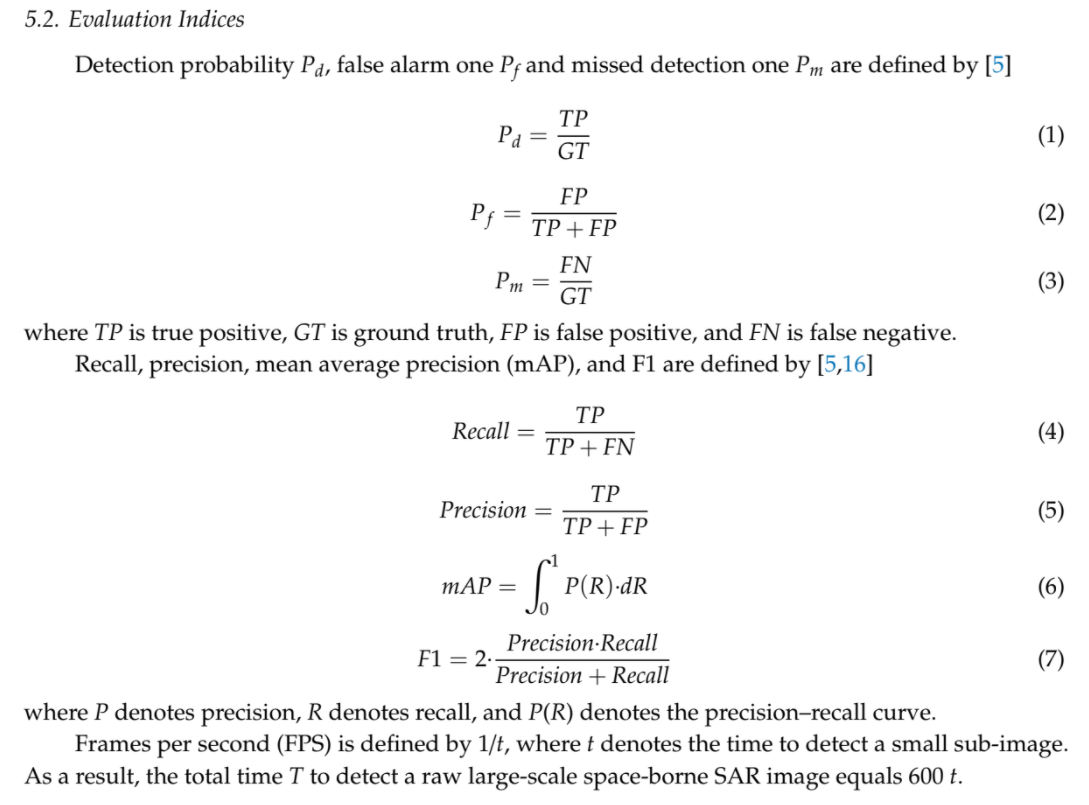


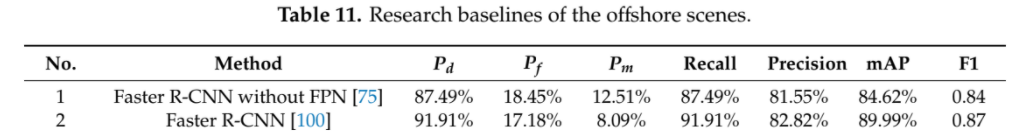

In [ ]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [ ]:
def average_precision(correct, ground_truth):
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)


  # Interpolate precision (replace each precision value with the maximum precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
test = [True, True, False, False, False, True, True, False, False, True]
recall, precision, AP = average_precision(test, 5)
assert AP == 0.5285714285714286
assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
assert precision == [1.0, 
                    1.0, 
                    0.6666666666666666,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5,
                    0.5,
                    0.5]

In [ ]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
  ):
    """
    Args:
        dataset_name (str): name of the dataset to be evaluated.
            It must have either the following corresponding metadata:

                "json_file": the path to the COCO format annotation

            Or it must be in detectron2's standard dataset format
            so it can be converted to COCO format automatically.
        output_dir (str): an output directory to dump all
            results predicted on the dataset. The dump contains two files:

            1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                a file that can be loaded with `torch.load` and
                contains all the results in the format they are produced by the model.
            2. "coco_instances_results.json" a json file in COCO's result format.
    """
    self._cpu_device = torch.device("cpu")
    self.dataset_name = dataset_name
    self._metadata = MetadataCatalog.get(dataset_name)
    self._output_dir = output_dir
    
    if not hasattr(self._metadata, "json_file"):
      cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
      self._metadata.json_file = cache_path
      convert_to_coco_json(dataset_name, cache_path)

    json_file = PathManager.get_local_path(self._metadata.json_file)
    with contextlib.redirect_stdout(io.StringIO()):
        self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.

    Args:
        inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
            It is a list of dict. Each dict corresponds to an image and
            contains keys like "height", "width", "file_name", "image_id".
        outputs: the outputs of a COCO model. It is a list of dicts with key
            "instances" that contains :class:`Instances`.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    
    if self._output_dir:
      PathManager.mkdirs(self._output_dir)
      file_path = os.path.join(self._output_dir,
                               self.dataset_name + "_predictions.pth")
#      file_path = os.path.join(self._output_dir, "instances_predictions.pth")
#      file_path = os.path.join(self._output_dir, f"{dataset_name}_predictions.pth") # NameError: name 'dataset_name' is not defined

      with PathManager.open(file_path, "wb") as f:
        torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    Evaluates on the whole dataset.
    """
    iou_threshold = 0.5
    num_instances = 0
    num_pos = 0  # must be equal to GT
    gt_overlaps = []
#    ap = [] 
    scores = []
    correct = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop over all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort in descending order
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

#      if len(predictions) == 0 or len(gt_boxes) == 0:
#        continue

      num_pos += len(gt_boxes)
      
      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores iou for each gt box in one image
      _scores = torch.zeros(len(in_scores)) # stores iou for each proposal box (score) in one image

      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)
          
          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]  # _gt_overlaps[gt_ind] ?
          assert _gt_overlaps[j] == gt_ovr  # _gt_overlaps[gt_ind] ?

          # record this iou coverage for score
          _scores[box_ind] = overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1
      
      # update collectors
      _correct = (_scores >= iou_threshold).tolist() # stores TP/FP for each proposal box in one image

      assert len(_correct) == len(_scores) == len(predictions)
      
#      _, __, _ap = average_precision(_correct, len(gt_boxes))

      # append recorded iou coverage level
      gt_overlaps.append(_gt_overlaps)
      scores.append(in_scores)
      correct.append(_correct)
#      ap.append(_ap)


    # all images
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)
    
    # stores TP/FP for each proposal box in all images (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection
    # assert (Pd + Pm) == 1

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2 * (precision * recall) / (precision + recall)
#    meanAP = np.array(ap).mean()
    recalls, precisions, mAP = average_precision(correct, GT)

    plot = {"recalls": recalls, "precisions": precisions}
    hist = {"gt_overlap": gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }

    return copy.deepcopy(self._results), plot, hist

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#val = './datasets/test/'

In [ ]:
# test_inshore
custEval = CustomEvaluator('ssdd_test_inshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[02/10 08:40:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 08:40:29 d2.data.common]: Serializing 766 elements to byte tensors and concatenating them all ...
[02/10 08:40:29 d2.data.common]: Serialized dataset takes 0.14 MiB
[02/10 08:40:29 d2.evaluation.evaluator]: Start inference on 766 images
[02/10 08:40:33 d2.evaluation.evaluator]: Inference done 11/766. 0.3139 s / img. ETA=0:04:02
[02/10 08:40:38 d2.evaluation.evaluator]: Inference done 27/766. 0.3126 s / img. ETA=0:03:58
[02/10 08:40:43 d2.evaluation.evaluator]: Inference done 43/766. 0.3122 s / img. ETA=0:03:53
[02/10 08:40:49 d2.evaluation.evaluator]: Inference done 59/766. 0.3119 s / img. ETA=0:03:50
[02/10 08:40:54 d2.evaluation.evaluator]: Inference done 75/766. 0.3121 s / img. ETA=0:03:44
[02/10 08:40:59 d2.evaluation.evaluator]: Inference done 90/766. 0.3124 s / img. ETA=0:03:41
[02/10 08:41:04 d2.

In [ ]:
eval, plot, hist = custEval.evaluate()
eval

{'F1': 0.3349282296650718,
 'FN': 673,
 'FP': 161,
 'GT': 883,
 'Pd': 0.23782559456398641,
 'Pf': 0.4339622641509434,
 'Pm': 0.7621744054360136,
 'TP': 210,
 'mAP': 0.16888973325918427,
 'precision': 0.5660377358490566,
 'recall': 0.23782559456398641}

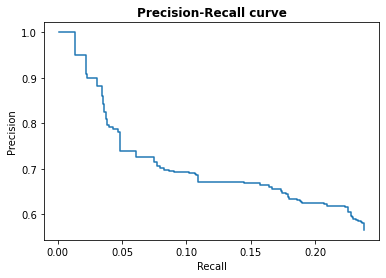

In [ ]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

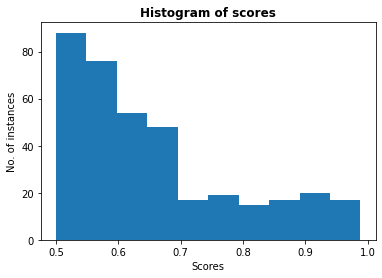

In [ ]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

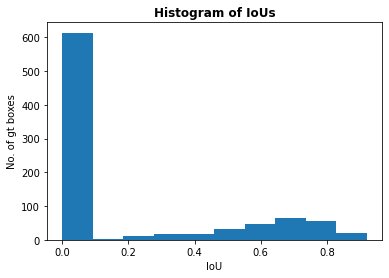

In [ ]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

In [ ]:
# test_offshore
custEval = CustomEvaluator('ssdd_test_offshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[02/10 08:46:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 08:46:09 d2.data.common]: Serializing 2234 elements to byte tensors and concatenating them all ...
[02/10 08:46:09 d2.data.common]: Serialized dataset takes 0.41 MiB
[02/10 08:46:09 d2.evaluation.evaluator]: Start inference on 2234 images
[02/10 08:46:13 d2.evaluation.evaluator]: Inference done 11/2234. 0.3108 s / img. ETA=0:11:50
[02/10 08:46:18 d2.evaluation.evaluator]: Inference done 27/2234. 0.3104 s / img. ETA=0:11:58
[02/10 08:46:24 d2.evaluation.evaluator]: Inference done 43/2234. 0.3103 s / img. ETA=0:11:57
[02/10 08:46:29 d2.evaluation.evaluator]: Inference done 59/2234. 0.3107 s / img. ETA=0:11:50
[02/10 08:46:34 d2.evaluation.evaluator]: Inference done 75/2234. 0.3109 s / img. ETA=0:11:44
[02/10 08:46:39 d2.evaluation.evaluator]: Inference done 90/2234. 0.3111 s / img. ETA=0:11:44
[02/10 08:4

In [ ]:
eval, plot, hist = custEval.evaluate()
eval

{'F1': 0.8233638282899367,
 'FN': 325,
 'FP': 177,
 'GT': 1495,
 'Pd': 0.782608695652174,
 'Pf': 0.13140311804008908,
 'Pm': 0.21739130434782608,
 'TP': 1170,
 'mAP': 0.7344454151678599,
 'precision': 0.8685968819599109,
 'recall': 0.782608695652174}

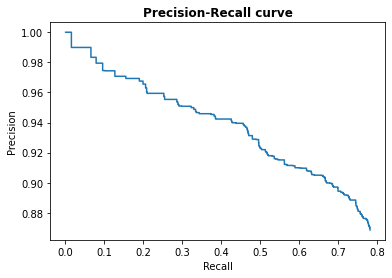

In [ ]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

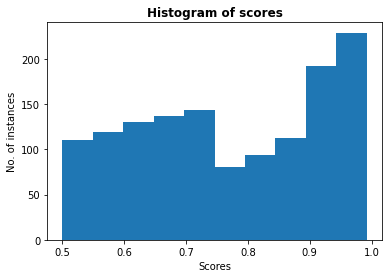

In [ ]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

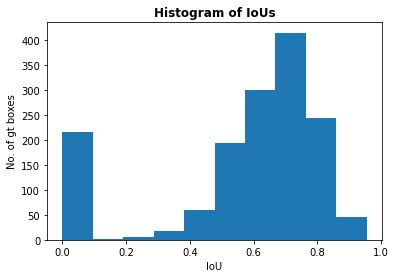

In [ ]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

In [ ]:
# test
custEval = CustomEvaluator('ssdd_test', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[02/10 09:04:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/10 09:04:54 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[02/10 09:04:54 d2.data.common]: Serialized dataset takes 0.53 MiB
[02/10 09:04:54 d2.evaluation.evaluator]: Start inference on 3000 images
[02/10 09:04:58 d2.evaluation.evaluator]: Inference done 11/3000. 0.3090 s / img. ETA=0:15:55
[02/10 09:05:03 d2.evaluation.evaluator]: Inference done 27/3000. 0.3089 s / img. ETA=0:15:48
[02/10 09:05:08 d2.evaluation.evaluator]: Inference done 43/3000. 0.3088 s / img. ETA=0:15:44
[02/10 09:05:14 d2.evaluation.evaluator]: Inference done 59/3000. 0.3096 s / img. ETA=0:15:50
[02/10 09:05:19 d2.evaluation.evaluator]: Inference done 74/3000. 0.3099 s / img. ETA=0:15:52
[02/10 09:05:24 d2.evaluation.evaluator]: Inference done 89/3000. 0.3100 s / img. ETA=0:15:51
[02/10 09:0

In [ ]:
eval, plot, hist = custEval.evaluate()
eval

{'F1': 0.673828125,
 'FN': 998,
 'FP': 338,
 'GT': 2378,
 'Pd': 0.5803195962994113,
 'Pf': 0.19674039580908032,
 'Pm': 0.41968040370058873,
 'TP': 1380,
 'mAP': 0.5301857613314918,
 'precision': 0.8032596041909197,
 'recall': 0.5803195962994113}

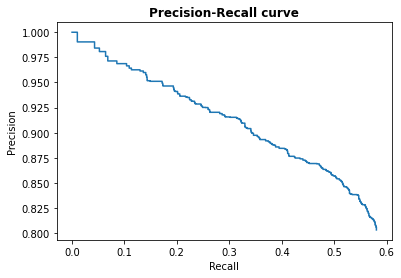

In [ ]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

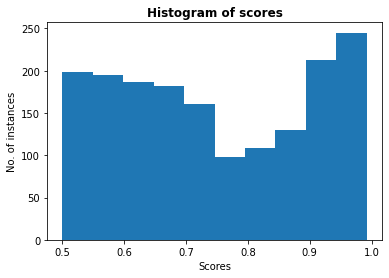

In [ ]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

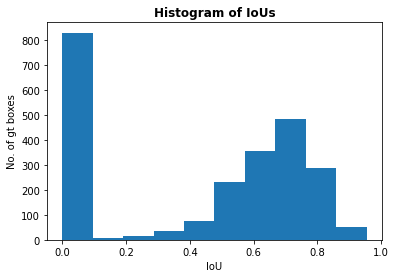

In [ ]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()